# Исследование продаж игр

## [1. Обзор данных](#data_review)

In [1]:
import re
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
%matplotlib inline

In [2]:
games_data = pd.read_csv('/datasets/games.csv')
games_data.columns = map(str.lower, games_data.columns)

Столбцы приведены к нижнему регистру, для удобства и соответствия PEP8.

In [3]:
games_data.info()
games_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## [2. Обработка данных](#data_preprocessing)

In [4]:
def convert_to_int(x):
    try:
        return int(x)
    except:
        return -1
    
def convert_to_float(x):
    try:
        return float(x)
    except:
        return -1

In [5]:
assert len(games_data.query('year_of_release % 1 != 0 & year_of_release != "NaN"')['year_of_release']) == 0, "В данных по году выхода присутствует дробная часть"
assert len(games_data.query('critic_score % 1 != 0 & critic_score != "NaN"')['critic_score']) == 0, "В данных по оценкам критиков присутствует дробная часть"

In [6]:
games_data['is_tbd'] = False
games_data.loc[games_data['user_score'] == 'tbd', 'is_tbd'] = True
games_data.loc[games_data['user_score'] == 'tbd', 'user_score'] = -1

Пометка tbd в пользовательских оценках означает, что количество отзывов и пользовательских оценок недостаточно для определения пользовательского рейтинга. Это указывает на то что либо игра не популярная, либо данные были получены в начале выхода игры и не были обновлены в дальшейнем. Такие данные можно выделить в отдельный столбец и заменить на -1 в столбце `user_score`.

In [7]:
games_data.loc[:, 'year_of_release'] = games_data.loc[:, 'year_of_release'].apply(convert_to_int)
games_data.loc[:, 'critic_score'] = games_data.loc[:, 'critic_score'].apply(convert_to_int)

games_data['na_sales'].fillna(value=-1, inplace=True)
games_data['eu_sales'].fillna(value=-1, inplace=True)
games_data['jp_sales'].fillna(value=-1, inplace=True)
games_data['other_sales'].fillna(value=-1, inplace=True)

games_data['user_score'].fillna(value=-1, inplace=True)
games_data.loc[:, 'user_score'] = games_data.loc[:, 'user_score'].apply(convert_to_float)

games_data['name'].fillna(value='unnamed', inplace=True)
games_data['name'] = games_data['name'].str.lstrip()

games_data['rating'].fillna(value='unknown', inplace=True)

Год выхода игры и оценка критиков представлены имеют тип данных с плавающей точкой, но все числа в наборе данных не имеют дробной части. 
Целесообразнее перевести в целочисленный тип. 

Пропущенные значения заменены на -1 в численных данных, на имени игры на 'unnamed', в рейтинге на 'unknown', для удобства обработки.

In [8]:
duplicate_games = games_data.loc[games_data.duplicated() == True].shape[0] / games_data.shape[0]
print(f'Процент дублированных данных: {duplicate_games:0.2%}')

Процент дублированных данных: 0.00%


Дуликатов в данных не обнаружено.

In [9]:
def check_na_percent(df, column, na_value=None):
    """
    Check percent NaN value on column in dataframe.

    Args:
        df (pandas DataFrame): dataframe to check
        by(str): column in dataframe
        na_value(int, str): specific NaN value
        
    Return: 
        float: Value of missing data
    """
    
    if na_value is None:
        df.loc[df[column].isna() == True].shape[0] / df.shape[0]
        
    return df.loc[df[column] == na_value].shape[0] / df.shape[0]

In [10]:
unamed_games_share = check_na_percent(games_data, column='name', na_value='unnamed')
print(f'Процент игр без названия: {unamed_games_share:0.2%}')

games_data = games_data.loc[games_data['name'] != 'unnamed']

Процент игр без названия: 0.01%


Так как процент игр без названия мал и заполнить пропуск данных о названии игры не возможно, то такие данные можно убрать.

In [11]:
unknown_platform_share = check_na_percent(games_data, column='platform')
print(f'Процент игр без указанной платфорфы: {unknown_platform_share:0.2%}')

Процент игр без указанной платфорфы: 0.00%


Пропуски в данных о платформе, на которой вышла игра, отсутствуют.

In [12]:
games_year_release_na = check_na_percent(games_data, column='year_of_release', na_value=-1)
print(f'Процент игр без года выхода: {games_year_release_na:0.2%}')

Процент игр без года выхода: 1.61%


В данных выхода игр присутствуют пропуски, вероятно ошибка при конвертации даты.

In [13]:
genre_release_na = check_na_percent(games_data, column='genre')
print(f'Процент игр без указанного жанра: {genre_release_na:0.2%}')

Процент игр без указанного жанра: 0.00%


Игры без указанного жанра отсутствуют.

In [14]:
us_sales_share = check_na_percent(games_data, column='na_sales', na_value=-1)
eu_sales_share = check_na_percent(games_data, column='eu_sales', na_value=-1)
jp_sales_share = check_na_percent(games_data, column='jp_sales', na_value=-1)
other_sales_share = check_na_percent(games_data, column='other_sales', na_value=-1)

print(f'Процент игр без данных по продажам в Северной Америке: {us_sales_share:0.2%}')
print(f'Процент игр без данных по продажам в Европе: {eu_sales_share:0.2%}')
print(f'Процент игр без данных по продажам в Японии: {jp_sales_share:0.2%}')
print(f'Процент игр без данных по продажам в других странах: {other_sales_share:0.2%}')

Процент игр без данных по продажам в Северной Америке: 0.00%
Процент игр без данных по продажам в Европе: 0.00%
Процент игр без данных по продажам в Японии: 0.00%
Процент игр без данных по продажам в других странах: 0.00%


Пропуски в данных по продажам отсутствуют.

In [15]:
games_data.query('name == "Resident Evil 4"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd
350,Resident Evil 4,PS2,2005,Action,2.08,0.83,0.46,0.25,96,8.9,M,False
732,Resident Evil 4,Wii,2007,Action,1.32,0.56,0.14,0.20,-1,-1.0,unknown,False
1068,Resident Evil 4,GC,2005,Action,0.98,0.42,0.22,0.06,96,9.4,M,False
14656,Resident Evil 4,PC,2007,Action,0.00,0.02,0.00,0.00,76,7.4,M,False


В данных присутствует большое количество пропусков в оценках критиков, пользователей а так же в возрастном рейтинге. Вероятная причина в том, что на момент сбора данных игра успела выйти. Например, не вышла на какой-то платформе.

In [16]:
def get_year_from_name(name):
    """Get release year from name of the game. Example FIFA Football 2005.
    
        Arg:
            name(str): name of the game 
            
        Return:
            int: Release year. If game with param name not found return -1.
    """
    year_reg = re.compile('^.*(?P<YYYY>\s\d{4})|(?P<_90s>\s9\d{1})|(?P<_00s>\s0\d{1})|(?P<YY_YY>\s\d{2}-\d{2})|(?P<YY_2K>\s2K\d$)|(?P<YY_2K0>\s2K\d{2}$)$')
    
    reg_dict = {}
    
    for item in year_reg.finditer(name):
        reg_dict = item.groupdict()    
    
    if len(reg_dict) == 0:
        return -1
    
    year_format = {}
    
    for key, value in reg_dict.items():
        if value is not None:
            year_format['format'] = key
            year_format['value'] = value.lstrip()
    
    result_year = 0
 
    if year_format['format'] == 'YYYY':
        result_year = int(year_format['value']) - 1
    elif year_format['format'] == '_90s':
        prev_year = int(year_format['value']) - 1
        result_year = int(f'19{prev_year}')
    elif year_format['format'] == '_00s':
        prev_year = int(year_format['value']) - 1
        result_year = int(f'200{prev_year}')
    elif year_format['format'] == 'YY_YY':
        raw_year = year_format['value'].split('-')
        result_year = int(f'{raw_year[0]}{raw_year[1]}') - 1    
    elif year_format['format'] == 'YY_2K':
        raw_year = year_format['value'].split('K')
        result_year = int(f'{raw_year[0]}00{raw_year[1]}') - 1    
    elif year_format['format'] == 'YY_2K0':
        raw_year = year_format['value'].split('K')
        result_year = int(f'{raw_year[0]}0{raw_year[1]}') - 1    
        
    return result_year

In [17]:
games_data.loc[games_data['year_of_release'] == -1, 'year_of_release'] = (games_data
                                                                                   .loc[games_data['year_of_release'] == -1, 'name']
                                                                                   .apply(get_year_from_name))

В названиях игр встречается год. Это обычно характерно для спортивных игр, в которых год указывает на следующий сезон игры. Потому выбираю из названия год и указываю год релиза на год раньше.

In [18]:
def get_year_from_other_platform(name):
    """Get release year from game on other platform with same.
    
        Arg:
            name(str): name of the game 
            
        Return:
            int: Release year. If game with param name not found return -1.
    """
    
    years_list = games_data.query('name == @name')['year_of_release'].sort_values().unique()
    
    if len(years_list) == 1:
        return -1
    
    return years_list[1]

In [19]:
names_without_date = list(games_data.loc[games_data['year_of_release'] == -1, 'name'].values)

for name in names_without_date:
    games_data.loc[(games_data['name'] == name) & 
                   (games_data['year_of_release'] == -1), 'year_of_release'] = (games_data
                                                                                .loc[(games_data['name'] == name) & 
                                                                                     (games_data['year_of_release'] == -1), 'name']
                                                                                .apply(get_year_from_other_platform))

В данных есть кроссплатформенные игры. Чаще всего выходят примерно в один год на всех платформах, год релиза игры можно взять в данных по другой платфоре.

In [20]:
def get_platforms():    
    """Get platforms list from RAWG Video Games Database API
    
        Return:
            Pandas DataFrame: return dataframe with platform fullname and platform Id. 
    
    """
    platforms_url = 'https://api.rawg.io/api/platforms'        
    platforms_response = requests.get(platforms_url)

    if platforms_response.status_code != 200:
        return platforms_response.status_code

    platforms_df = pd.DataFrame(data=platforms_response.json()['results'])
    
    platforms_df.drop(columns=['slug', 'games_count', 'image_background', 'image', 'year_start', 'year_end', 'games'], inplace=True)
    platforms_df.rename(columns={'id': 'platform_id', 'name': 'platform_fullname'}, inplace=True)
    
    platform_list = list(games_data['platform'].unique())

    for platform_item in platform_list[:]:
        platforms_df.loc[platforms_df['platform_fullname'] == platform_item, 'platform'] = platform_item

    platforms_df.loc[platforms_df['platform_fullname'] == 'Atari 2600', 'platform'] = '2600'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Nintendo 3DS', 'platform'] = '3DS'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Dreamcast', 'platform'] = 'DC'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Nintendo DS', 'platform'] = 'DS'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Game Boy', 'platform'] = 'GB'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Game Boy Advance', 'platform'] = 'GBA'
    platforms_df.loc[platforms_df['platform_fullname'] == 'GameCube', 'platform'] = 'GC'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Genesis', 'platform'] = 'GEN'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Game Gear', 'platform'] = 'GG'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Nintendo 64', 'platform'] = 'N64'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Neo Geo', 'platform'] = 'NG'
    platforms_df.loc[platforms_df['platform_fullname'] == 'PlayStation', 'platform'] = 'PS'
    platforms_df.loc[platforms_df['platform_fullname'] == 'PlayStation 2', 'platform'] = 'PS2'
    platforms_df.loc[platforms_df['platform_fullname'] == 'PlayStation 3', 'platform'] = 'PS3'
    platforms_df.loc[platforms_df['platform_fullname'] == 'PlayStation 4', 'platform'] = 'PS4'
    platforms_df.loc[platforms_df['platform_fullname'] == 'PS Vita', 'platform'] = 'PSV'
    platforms_df.loc[platforms_df['platform_fullname'] == 'SEGA Saturn', 'platform'] = 'SAT'
    platforms_df.loc[platforms_df['platform_fullname'] == 'SEGA CD', 'platform'] = 'SCD'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Wii U', 'platform'] = 'WiiU'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Xbox 360', 'platform'] = 'X360'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Xbox', 'platform'] = 'XB'
    platforms_df.loc[platforms_df['platform_fullname'] == 'Xbox One', 'platform'] = 'XOne'

    del platform_list
    platforms_df.dropna(inplace=True)
    
    return platforms_df

In [21]:
platforms_data = get_platforms()

In [22]:
columns = ['name',
           'platform',
           'platform_fullname', 
           'platform_id', 
           'year_of_release',
           'genre',
           'na_sales',
           'eu_sales',
           'jp_sales',
           'other_sales',
           'critic_score',
           'user_score',
           'rating',
           'is_tbd']

games_data = games_data.merge(platforms_data, on='platform', how='outer')
games_data = games_data[columns]

In [23]:
games_data['platform_fullname'].fillna(value=-1, inplace=True)
games_data['platform_id'].fillna(value=-1, inplace=True)

games_data['platform_id'] = games_data['platform_id'].astype(int)

Год выхода игр предполагается получить из базы данных игр rawg.io. В запросе можно передать платформу на которой игра выходила. Для этого нужно получить список платформ в базе и сопоставить с игровыми платформами в датасете.

In [24]:
games_data.loc[games_data['year_of_release'] == -1][['name','platform','platform_fullname','platform_id']].head(5)

,name,platform,platform_fullname,platform_id
60,Rock Band,Wii,Wii,11
388,NHL Slapshot,Wii,Wii,11
446,Dragon Ball Z: Budokai Tenkaichi 2 (JP sales),Wii,Wii,11
595,Big Beach Sports 2,Wii,Wii,11
632,DanceDanceRevolution II,Wii,Wii,11


In [25]:
def get_release_year(row):    
    """Get release year from RAWG Video Games Database API

    Return 
        str: If name from response match to name in param, return release year. Else return -1.
        int: If status code not 200, return error status code.
    """
    name = row['name']
    platform_id = row['platform_id']
    
    api_url = 'https://api.rawg.io/api/games'
    api_response = requests.get(api_url,
                                params={'search': name,
                                        'platforms': platform_id,
                                        'page_size': 1
                                       })
    
    if api_response.status_code != 200:
        return api_response.status_code
    
    if len(api_response.json()['results']) == 0:
        return -1

    response_name = api_response.json()['results'][0]['name']
    release_date = api_response.json()['results'][0]['released']
    
    if response_name != name:
        return -1
    
    if release_date is None:
        return -1
    
    dt = datetime.strptime(release_date, '%Y-%m-%d')
    
    return int(dt.year)

In [26]:
games_data.loc[games_data['year_of_release'] == -1, 'year_of_release'] = (games_data
                                                                          .loc[games_data['year_of_release'] == -1]
                                                                          .apply(get_release_year, axis=1))

games_data['year_of_release'] = games_data['year_of_release'].astype(int)
games_data.loc[games_data['year_of_release'] == -1]

,name,platform,platform_fullname,platform_id,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd
446,Dragon Ball Z: Budokai Tenkaichi 2 (JP sales),Wii,Wii,11,-1,Action,0.15,0.05,0.14,0.01,-1,-1.0,unknown,False
632,DanceDanceRevolution II,Wii,Wii,11,-1,Misc,0.20,0.00,0.00,0.01,-1,-1.0,E10+,True
791,Our House Party!,Wii,Wii,11,-1,Simulation,0.13,0.00,0.00,0.01,-1,-1.0,unknown,False
990,Zero: Tsukihami no Kamen,Wii,Wii,11,-1,Action,0.00,0.00,0.08,0.00,-1,-1.0,unknown,False
1130,Reader Rabbit 2nd Grade,Wii,Wii,11,-1,Misc,0.04,0.00,0.00,0.00,-1,-1.0,E,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14557,Prinny: Can I Really Be The Hero? (US sales),PSP,PSP,17,-1,Action,0.06,0.00,0.00,0.00,-1,-1.0,unknown,False
14713,Half-Minute Hero 2,PSP,PSP,17,-1,Role-Playing,0.00,0.00,0.04,0.00,-1,-1.0,unknown,False
14746,Fullmetal Alchemist: Brotherhood,PSP,PSP,17,-1,Action,0.00,0.00,0.03,0.00,-1,-1.0,unknown,False
14823,Payout Poker & Casino,PSP,PSP,17,-1,Misc,0.02,0.00,0.00,0.00,-1,-1.0,unknown,False


Год выхода игр которые не удалось извлечь из датасета, был взят из базы данных игр rawg.io. 

In [27]:
def get_note_from_name(row):
    note_reg = r'\(.*(sale|Sale|weekly|old|Old|wrong|Wrong).*\)$'
    
    note_part = re.search(note_reg, row['name'])
    
    if note_part is None:
        return None
    
    return note_part.group(0).lstrip()


def remove_note_from_name(row):
    name = row['name']

    note_reg = r'\(.*(sale|Sale|weekly|old|Old|wrong|Wrong).*\)$'
    name_without_note = re.split(note_reg, name)[0]
    
    return name_without_note

In [28]:
games_data['note'] = games_data.apply(get_note_from_name, axis=1)
games_data.loc[games_data['note'].isna() == False, 'name'] = games_data.loc[games_data['note'].isna() == False].apply(remove_note_from_name, axis=1)
games_data.loc[games_data['note'].isna() == False, 'note'] = games_data.loc[games_data['note'].isna() == False, 'note'].str.strip('(|)').str.lower()

In [29]:
games_data.reset_index(drop=True, inplace=True)

В датасете присутвует менее 1% игр с с пометками о продаже в каком-то определенном регионе или о продажи за неделю. У подобных записей отсутствуют оценки критиков, оценки пользователей и возрастной рейтинг. Это похоже на неофициальные данные продаж, подобные данные можно исключить из анализа.

In [30]:
critic_pivot = games_data.loc[(games_data['note'].isna()) & (games_data['critic_score'] != -1)].pivot_table(index=['name', 'year_of_release'], values='critic_score')
critic_pivot.columns = ['critic_score_mean']
critic_pivot.reset_index(inplace=True)
critic_pivot['critic_score_mean'] = round(critic_pivot['critic_score_mean'], ndigits=None).astype(int)

user_pivot = games_data.loc[(games_data['note'].isna()) & (games_data['user_score'] != -1)].pivot_table(index=['name', 'year_of_release'], values='user_score')
user_pivot.columns = ['user_score_mean']
user_pivot.reset_index(inplace=True)
user_pivot['user_score_mean'] = round(user_pivot['user_score_mean'], ndigits=1)

In [31]:
def get_score(row, df, column):
    """Pandas apply function for get mean score from pivot table

    Args: 
        row(Pandas Series): Apply fuction row
        df(Pandas DataFrame): Pivot table with mean score
        column(str): Mean score column

    Return:
        int: If name and release year from pivot match to row, return score value. Else return -1. 
    """
    score = df.loc[(df['name'] == row['name']) & (df['year_of_release'] == row['year_of_release']), column]
    
    if len(score) == 0:
        return -1
    
    return score.values[0]

def get_rating(row, df):
    """Pandas apply function for get rating.

    Args: 
        row(Pandas Series): Apply fuction row
        df(Pandas DataFrame): DataFrame with data

    Return:
        int: If name and release year from pivot match to row, return rating value. Else return -1. 
    """
    rating = df.loc[(df['name'] == row['name']) & (df['year_of_release'] == row['year_of_release']) & (df['rating'] != 'unknown'), 'rating'].unique()
    
    if len(rating) == 0:
        return -1
    
    return rating[0]

In [32]:
critic_score_share = check_na_percent(games_data, column='critic_score', na_value=-1)
user_score_share = check_na_percent(games_data, column='user_score', na_value=-1)
rating_score_share = check_na_percent(games_data, column='rating', na_value='unknown')

print(f'Процент пропусков оценок критиков: {critic_score_share:0.2%}')
print(f'Процент пропусков оценок пользователей: {user_score_share:0.2%}')
print(f'Процент пропусков рейтингов: {rating_score_share:0.2%}')

Процент пропусков оценок критиков: 51.31%
Процент пропусков оценок пользователей: 54.59%
Процент пропусков рейтингов: 40.47%


In [33]:
games_data.query('name == "pro evolution soccer 2011"')

,name,platform,platform_fullname,platform_id,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd,note
601,pro evolution soccer 2011,Wii,Wii,11,2010,Sports,0.07,0.10,0.03,0.02,78,5.4,E,False,None
4039,pro evolution soccer 2011,X360,Xbox 360,14,2010,Sports,0.09,0.44,0.00,0.07,79,5.9,E,False,None
5003,pro evolution soccer 2011,PS3,PlayStation 3,16,2010,Sports,0.29,1.17,0.54,0.41,77,6.8,E,False,None
7004,pro evolution soccer 2011,PS2,PlayStation 2,15,2010,Sports,0.04,0.21,0.05,0.11,-1,6.7,E,False,None
13151,pro evolution soccer 2011,PC,PC,4,2010,Sports,0.00,0.05,0.00,0.01,79,-1.0,unknown,False,None
13921,pro evolution soccer 2011,PSP,PSP,17,2010,Sports,0.05,0.30,0.29,0.16,74,5.8,E,False,None


In [34]:
games_data.loc[(games_data['critic_score'] == -1), 'critic_score'] = (games_data
                                                                      .loc[(games_data['critic_score'] == -1)]
                                                                      .apply(get_score, axis=1, df=critic_pivot, column='critic_score_mean'))

games_data.loc[(games_data['user_score'] == -1), 'user_score'] = (games_data
                                                                      .loc[(games_data['user_score'] == -1)]
                                                                      .apply(get_score, axis=1, df=user_pivot, column='user_score_mean'))

games_data.loc[(games_data['rating'] == 'unknown'), 'rating'] = (games_data.loc[(games_data['rating'] == 'unknown')].apply(get_rating, axis=1, df=games_data))

In [35]:
critic_score_share = check_na_percent(games_data, column='critic_score', na_value=-1)
user_score_share = check_na_percent(games_data, column='user_score', na_value=-1)
rating_score_share = check_na_percent(games_data, column='rating', na_value='unknown')

print(f'Процент пропусков оценок критиков: {critic_score_share:0.2%}')
print(f'Процент пропусков оценок пользователей: {user_score_share:0.2%}')
print(f'Процент пропусков рейтингов: {rating_score_share:0.2%}')

Процент пропусков оценок критиков: 46.98%
Процент пропусков оценок пользователей: 49.63%
Процент пропусков рейтингов: 0.00%


In [36]:
games_data.query('name == "pro evolution soccer 2011"')

,name,platform,platform_fullname,platform_id,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,is_tbd,note
601,pro evolution soccer 2011,Wii,Wii,11,2010,Sports,0.07,0.10,0.03,0.02,78,5.4,E,False,None
4039,pro evolution soccer 2011,X360,Xbox 360,14,2010,Sports,0.09,0.44,0.00,0.07,79,5.9,E,False,None
5003,pro evolution soccer 2011,PS3,PlayStation 3,16,2010,Sports,0.29,1.17,0.54,0.41,77,6.8,E,False,None
7004,pro evolution soccer 2011,PS2,PlayStation 2,15,2010,Sports,0.04,0.21,0.05,0.11,77,6.7,E,False,None
13151,pro evolution soccer 2011,PC,PC,4,2010,Sports,0.00,0.05,0.00,0.01,79,6.1,E,False,None
13921,pro evolution soccer 2011,PSP,PSP,17,2010,Sports,0.05,0.30,0.29,0.16,74,5.8,E,False,None


## [3. Исследование данных](#data_research)

### [3.1 Количество выпущенных игр в разные годы](#games_count_by_release_year)

In [37]:
games_data.insert(loc=10, column='total_sales', value=None)
games_data['total_sales'] = games_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [38]:
games_stat_col = [col for col in games_data.columns if col != 'note']
games_stat = games_data.loc[(games_data['note'].isna()) & (games_data['year_of_release'] != -1), games_stat_col]

In [39]:
year_of_release_pivot = games_stat.pivot_table(index='year_of_release', values='name', aggfunc='count')
year_of_release_pivot.columns = ['count']
year_of_release_pivot.reset_index(inplace=True)

year_of_release_pivot.head(5)

,year_of_release,count
0,1977,2
1,1979,1
2,1980,11
3,1981,46
4,1982,37


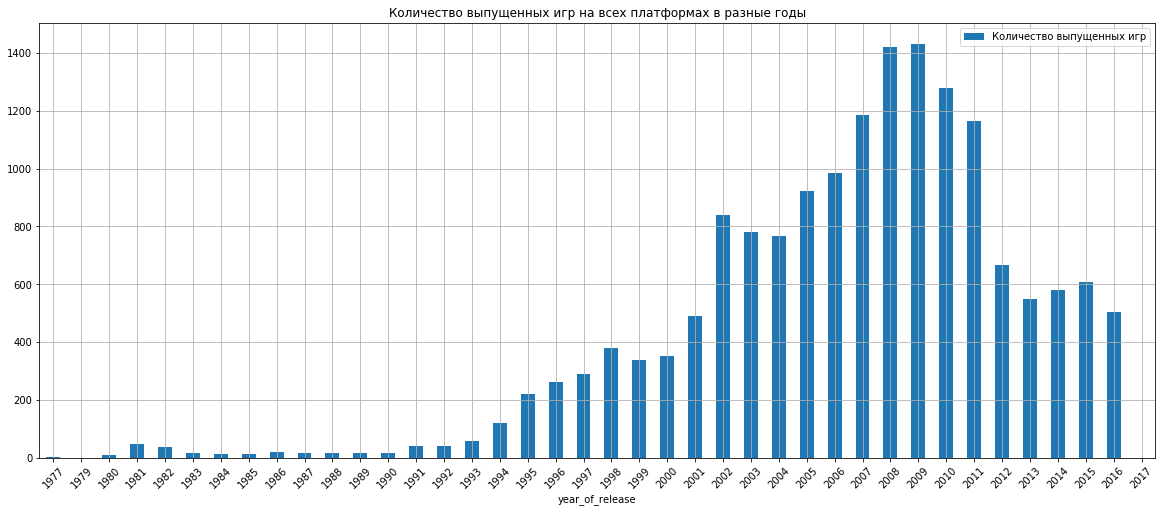

In [40]:
year_of_release_pivot.plot(x='year_of_release', y='count', kind='bar', grid=True, figsize=(20, 8), title='Количество выпущенных игр на всех платформах в разные годы')
plt.legend(labels=['Количество выпущенных игр'])
plt.xticks(rotation=45)
plt.show()

Из данного графика видно что количество игр росло с середины 90х до пика в 2008 году. После количество выпускаемых игр снижалось до 2012 года. Можно предположить, что причиной снижения послужил экономический кризис.

In [41]:
ps4_start_year = games_stat.loc[(games_stat['platform'] == 'PS4'), 'year_of_release'].min()
xbox_one_start_year = games_stat.loc[(games_stat['platform'] == 'XOne'), 'year_of_release'].min()
wiiu_start_year = games_stat.loc[(games_stat['platform'] == 'WiiU'), 'year_of_release'].min()

print(f'Старт продаж игр Playstation 4: {ps4_start_year}')
print(f'Старт продаж игр Xbox One: {xbox_one_start_year}')
print(f'Старт продаж игр WiiU: {wiiu_start_year}')

Старт продаж игр Playstation 4: 2013
Старт продаж игр Xbox One: 2013
Старт продаж игр WiiU: 2012


Время выхода текущих игровых платформ и график показывают что актуальным периодом для дальнейшего исследования является период 2012-2016 год.

In [42]:
stat_current_period = games_stat.loc[games_stat['year_of_release'] >= 2012]

### [3.2 Исследование продаж по платформам](#sales_by_platform)

In [43]:
def get_top_platforms(df, head=None):
    """Get top 10 gaming platforms by sales of games.

    Args: 
        df(Pandas DataFrame): DataFrame with data

    Return:
        list(str): Return list with top 10 gaming platforms.
    """
    platforms_list = list(df['platform'].unique())
    
    top_platforms = {}

    for platform_item in platforms_list:
        top_platforms[platform_item] = df.loc[df['platform'] == platform_item, 'total_sales'].sum()
    
    top_platforms = {key: value for key, value in sorted(top_platforms.items(), key=lambda item: item[1], reverse=True)}
    return list(top_platforms.keys())[0:head]

In [44]:
platforms_rank = get_top_platforms(games_data, head=10)

In [45]:
def total_sales_platform_plot(df, platform, axis=None):
    """Show plot for total sales on target platform

    Args: 
        df(Pandas DataFrame): DataFrame with data
        platform(str): Platform name from dataframe
    """
    fullname = df.loc[df['platform'] == platform, 'platform_fullname'].head(1).to_list()[0]
    plot_title = f'График продаж игр {fullname} в разные годы'
    plot_legend = f'Продажи на платформе {fullname}'
    
    if fullname == -1:
        plot_title = platform
        plot_legend = platform
    
    platform_pivot = df.loc[df['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    platform_pivot.reset_index(inplace=True)

    if axis is not None:
        axis.bar(x=platform_pivot['year_of_release'], height=platform_pivot['total_sales'])
        axis.set_xticks(ticks=platform_pivot['year_of_release'])
        axis.set_xticklabels(labels=platform_pivot['year_of_release'], rotation=45)
        axis.title.set_text(plot_title)
        axis.legend(labels=[plot_legend], loc='upper right')
    else:
        platform_pivot.plot(x='year_of_release', y='total_sales', kind='bar', grid=True, figsize=(12, 6), title=plot_title)
        plt.legend(labels=[plot_legend])
        plt.xticks(rotation=45)

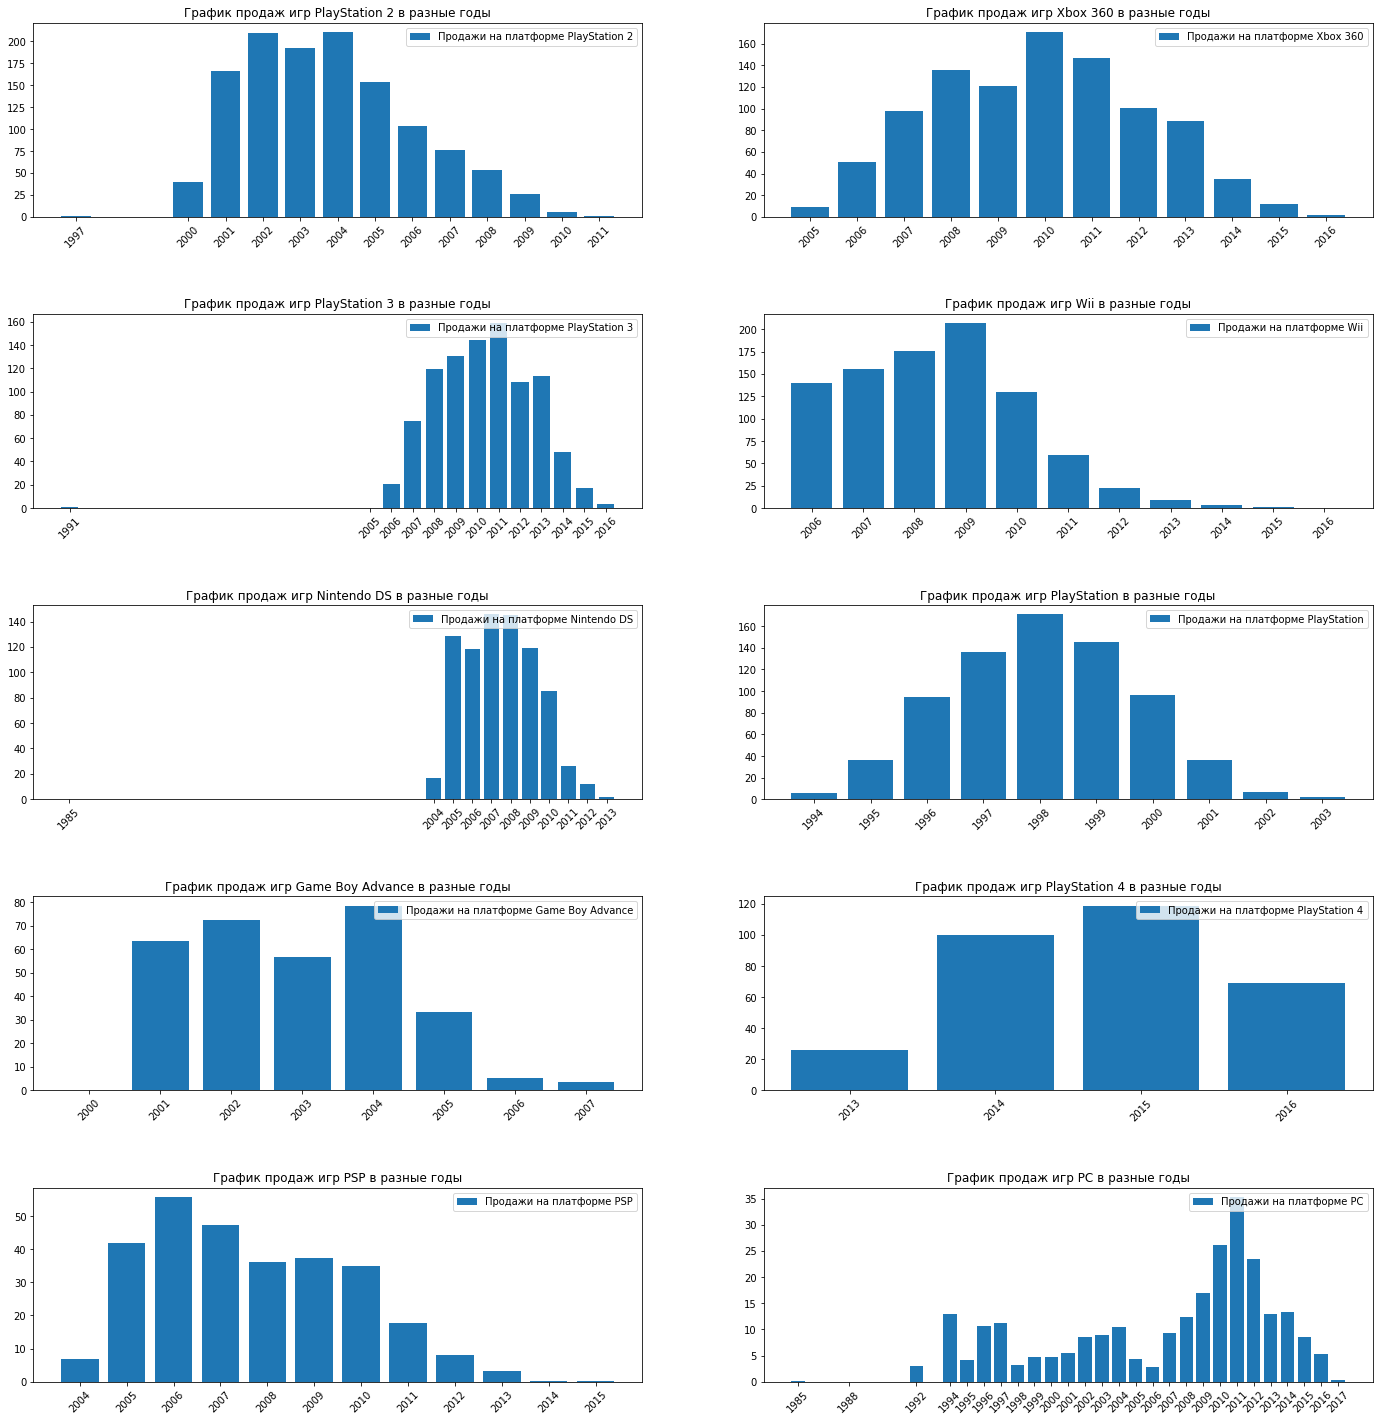

In [46]:
fig_platforms, ax_platforms = plt.subplots(len(platforms_rank) // 2, 2, figsize=(24, 25), squeeze=False)

for index, ax_item in enumerate(ax_platforms.flatten()):
    if index > len(platforms_rank) - 1:
        fig_platforms.delaxes(ax_platforms.flatten()[index])
        break
        
    total_sales_platform_plot(df=games_stat, platform=platforms_rank[index], axis=ax_item)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

Из графиков распределения продаж игровых платформ видно что срок жизни платфоры примерно 6-7 лет. Пик продаж приходится на середину жизненного цикла и дальше идет спад.

In [47]:
ps4_start_year = games_stat.loc[(games_stat['platform'] == 'PS4'), 'year_of_release'].min()
xbox_one_start_year = games_stat.loc[(games_stat['platform'] == 'XOne'), 'year_of_release'].min()
wiiu_start_year = games_stat.loc[(games_stat['platform'] == 'WiiU'), 'year_of_release'].min()

print(f'Старт продаж игр Playstation 4: {ps4_start_year}')
print(f'Старт продаж игр Xbox One: {xbox_one_start_year}')
print(f'Старт продаж игр WiiU: {wiiu_start_year}')

print(platforms_rank)

Старт продаж игр Playstation 4: 2013
Старт продаж игр Xbox One: 2013
Старт продаж игр WiiU: 2012
['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']


Время выхода текущих игровых платформ и графики распределения продаж показывают что текущие игровые платформы находятся примерно в середине своего жизненного цикла. **Актуальным периодом** для прогнозирования продаж на 2017 год является период **с 2013 по 2016 год**.

In [48]:
stat_current_period = games_data.loc[games_data['year_of_release'] >= 2013]

### [3.3 Определение потенциально прибыльных платформ на текущий момент.](#profitable_platforms_current_period)

In [49]:
current_platforms = get_top_platforms(stat_current_period, head=10)

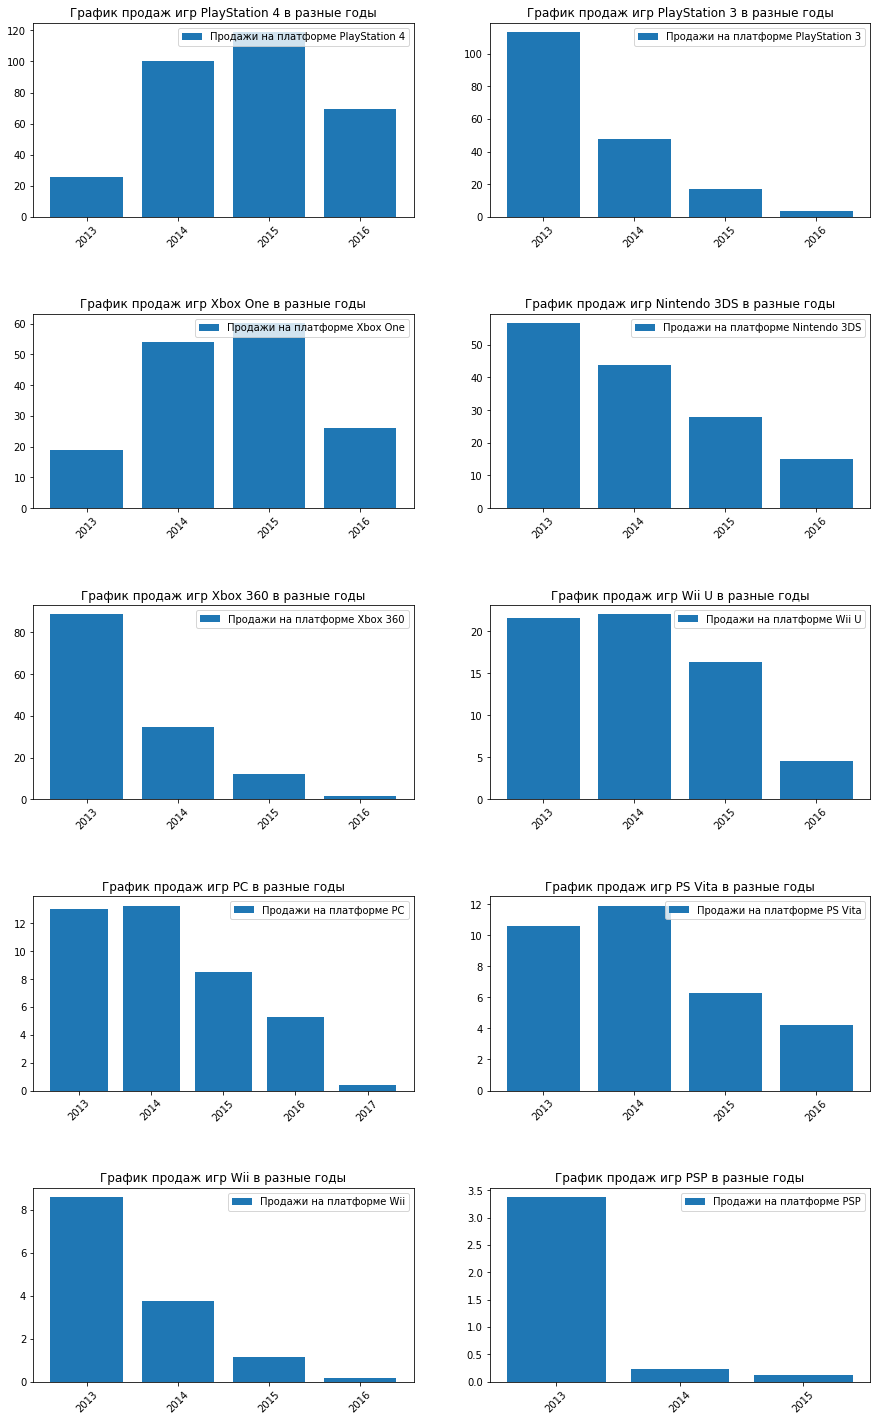

In [50]:
fig_current_platforms, ax_current_platforms = plt.subplots(len(current_platforms) // 2, 2, figsize=(15, 25))

for index, ax_item in enumerate(ax_current_platforms.flatten()):
    if index > len(current_platforms) - 1:
        fig_platforms.delaxes(ax_platforms.flatten()[index])
        break
        
    total_sales_platform_plot(df=stat_current_period, platform=current_platforms[index], axis=ax_item)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

Лидерами продаж текущий период являются Playstation 4, Playstation 3, Xbox One, Nintendo 3DS. На графиках видно снижение продаж всех платформ, возможная причина этому переход игроков на мобильные платформы и бесплатные или условно-бесплатные (free-to-play) игры. Потенциально прибыльными являются платформы Playstation 4, Xbox One. Жизненный цикл Playstation 3 подошел к концу, на его замену пришла более новая консоль и это так же видно на графике продаж. График продаж игр на Nintendo 3DS так же указывает на возможную смену поколения, а так же популярность данной платфорны более характерна для японского и американского рынков. \
При планировании продаж на 2017 год стоит ориентироваться на платфоры Playstation 4 и Xbox One, преимущественно на Playstation 4.

### [3.4 Исследование продаж на платформах Playstation 4 и Xbox One.](#ps4_xone_compare)

In [51]:
stat_current_period.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 33 to 16508
Data columns (total 16 columns):
name                 2240 non-null object
platform             2240 non-null object
platform_fullname    2240 non-null object
platform_id          2240 non-null int64
year_of_release      2240 non-null int64
genre                2240 non-null object
na_sales             2240 non-null float64
eu_sales             2240 non-null float64
jp_sales             2240 non-null float64
other_sales          2240 non-null float64
total_sales          2240 non-null float64
critic_score         2240 non-null int64
user_score           2240 non-null float64
rating               2240 non-null object
is_tbd               2240 non-null bool
note                 0 non-null object
dtypes: bool(1), float64(6), int64(3), object(6)
memory usage: 282.2+ KB


In [52]:
ps4_total_sales_stat = stat_current_period.loc[stat_current_period['platform'] == "PS4"]
xone_total_sales_stat = stat_current_period.loc[stat_current_period['platform'] == "XOne"]

In [53]:
def draw_boxplot(df, column, xlim=None, size=None, legend=None, title=None):
    """Show boxplot from dataframe with column

    Args: 
        df(Pandas DataFrame): DataFrame with data
        column(str): Column to show boxplot
        xlim(list): Left, right limit
        title(str): Plot title
        label(str): Axis label
    """
        
    df.plot(y=column, kind='box', vert=False, grid=True, figsize=size, title=title)
    plt.legend([legend])
    plt.xlim(xlim)

In [54]:
ps4_total_sales_stat['total_sales'].describe()

count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

In [55]:
xone_total_sales_stat['total_sales'].describe()

count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64

In [56]:
ps4_tail_value = ps4_total_sales_stat['total_sales'].quantile(q=0.75)

ps4_head_sales = ps4_total_sales_stat.loc[ps4_total_sales_stat['total_sales'] <= ps4_tail_value, 'total_sales'].sum()
ps4_tail_sales = ps4_total_sales_stat.loc[ps4_total_sales_stat['total_sales'] > ps4_tail_value, 'total_sales'].sum()
print(f'Продажи основной массы игр на Playstation 4: {ps4_head_sales:0.2f} млн.$')
print(f'Продажи наиболее прибыльных игр на Playstation 4: {ps4_tail_sales:0.2f} млн.$')

Продажи основной массы игр на Playstation 4: 54.01 млн.$
Продажи наиболее прибыльных игр на Playstation 4: 260.13 млн.$


In [57]:
xone_tail_value = xone_total_sales_stat['total_sales'].quantile(q=0.75)

xone_head_sales = xone_total_sales_stat.loc[xone_total_sales_stat['total_sales'] <= xone_tail_value, 'total_sales'].sum()
xone_tail_sales = xone_total_sales_stat.loc[xone_total_sales_stat['total_sales'] > xone_tail_value, 'total_sales'].sum()
print(f'Продажи основной массы игр на Xbox One: {xone_head_sales:0.2f} млн.$')
print(f'Продажи наиболее прибыльных игр на Xbox One: {xone_tail_sales:0.2f} млн.$')

Продажи основной массы игр на Xbox One: 35.56 млн.$
Продажи наиболее прибыльных игр на Xbox One: 123.76 млн.$


In [58]:
print(f'Разница продаж основной массы игр между Playstation 4 и Xbox One: {(abs(ps4_head_sales - xone_head_sales) / xone_head_sales):0.2%}')
print(f'Разница продаж наиболее прибыльных игр между Playstation 4 и Xbox One: {(abs(ps4_tail_sales - xone_tail_sales) / xone_tail_sales):0.2%}')

Разница продаж основной массы игр между Playstation 4 и Xbox One: 51.88%
Разница продаж наиболее прибыльных игр между Playstation 4 и Xbox One: 110.19%


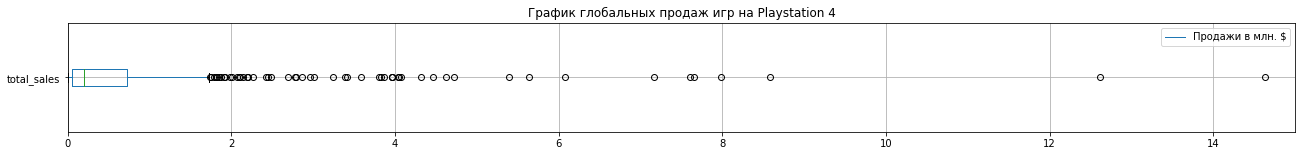

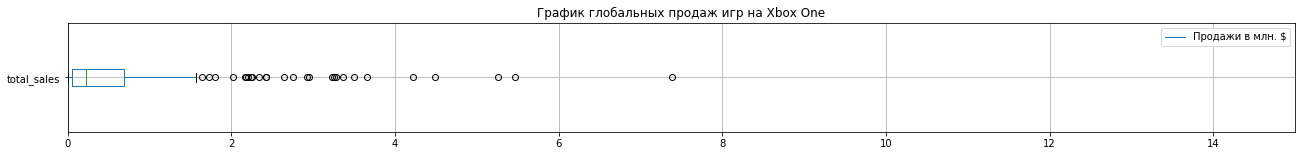

In [59]:
draw_boxplot(df=ps4_total_sales_stat, column='total_sales', xlim=[0, 15], size=[22, 2], title='График глобальных продаж игр на Playstation 4', legend='Продажи в млн. $')
draw_boxplot(df=xone_total_sales_stat, column='total_sales', xlim=[0, 15], size=[22, 2], title='График глобальных продаж игр на Xbox One', legend='Продажи в млн. $')

plt.show()

In [60]:
total_sales_mean_diff = ps4_total_sales_stat['total_sales'].mean() - xone_total_sales_stat['total_sales'].mean()
print(f'Разница средних продаж между Playstation 4 и Xbox One {total_sales_mean_diff:0.2%}')

Разница средних продаж между Playstation 4 и Xbox One 15.64%


Разница глобальных продаж основной массы игры на платформах Playstation 4 и Xbox One не велика. На PS4 больше прибыльных игр, с общим доходом выше основной части игр. Так же такие игры приносят больше денег чем на Xbox One. \
Cуммарные продажи основной массы и наиболее прибыльных игр выше на последнем поколении Playstation, на 51% и 112% соответственно. \
Продажи остальных остальных платформ существенно ниже чем у Playstation 4 и Xbox One.

### [3.5 Исследование продаж игр на платформе Playstation 4.](#ps4_games_research)

Для исследования влияния оценок пользователей и критиков на продажи выбрана одна из самых популярных и прибыльных платформ Playstation 4.

In [61]:
ps4_data = (stat_current_period.loc[(stat_current_period['platform'] == 'PS4') & 
                                    (stat_current_period['total_sales'] != -1) & 
                                    (stat_current_period['critic_score'] != -1) & 
                                    (stat_current_period['user_score'] != -1)])

ps4_pivot = ps4_data.pivot_table(index='name', values=['total_sales', 'critic_score', 'user_score'])
ps4_pivot.reset_index(inplace=True)
ps4_pivot.corr()

,critic_score,total_sales,user_score
critic_score,1.000000,0.403777,0.560747
total_sales,0.403777,1.000000,-0.029933
user_score,0.560747,-0.029933,1.000000


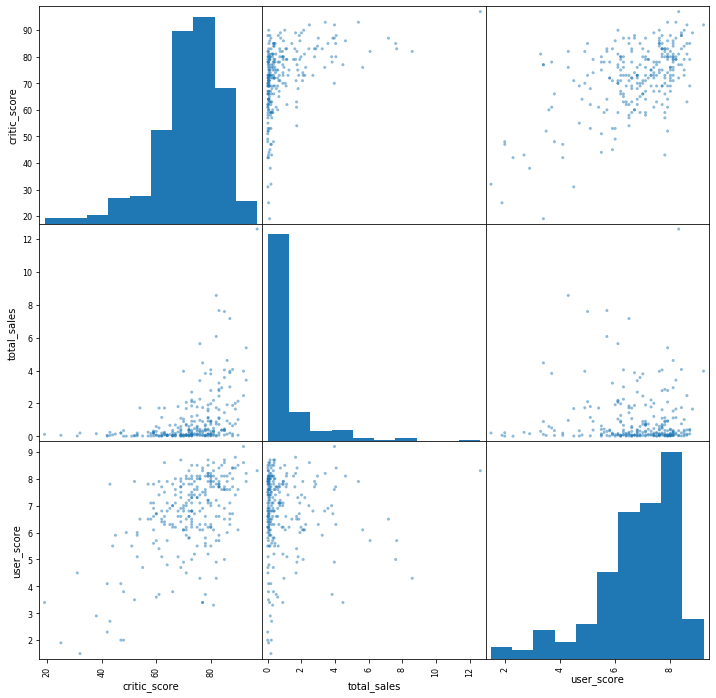

In [62]:
pd.plotting.scatter_matrix(ps4_pivot, figsize=(12, 12))
plt.show()

На продажи игры слабо влияет оценка критиков и никаким образом не оказывает влияния оценка пользователей. 

### [3.6 Исследование продаж игр на платформе Xbox One.](#xone_games_research)

In [63]:
xone_data = (stat_current_period.loc[(stat_current_period['platform'] == 'XOne') & 
                                    (stat_current_period['total_sales'] != -1) & 
                                    (stat_current_period['critic_score'] != -1) & 
                                    (stat_current_period['user_score'] != -1)])

xone_pivot = xone_data.pivot_table(index='name', values=['total_sales', 'critic_score', 'user_score'])
xone_pivot.reset_index(inplace=True)
xone_pivot.corr()

,critic_score,total_sales,user_score
critic_score,1.000000,0.407351,0.467322
total_sales,0.407351,1.000000,-0.073109
user_score,0.467322,-0.073109,1.000000


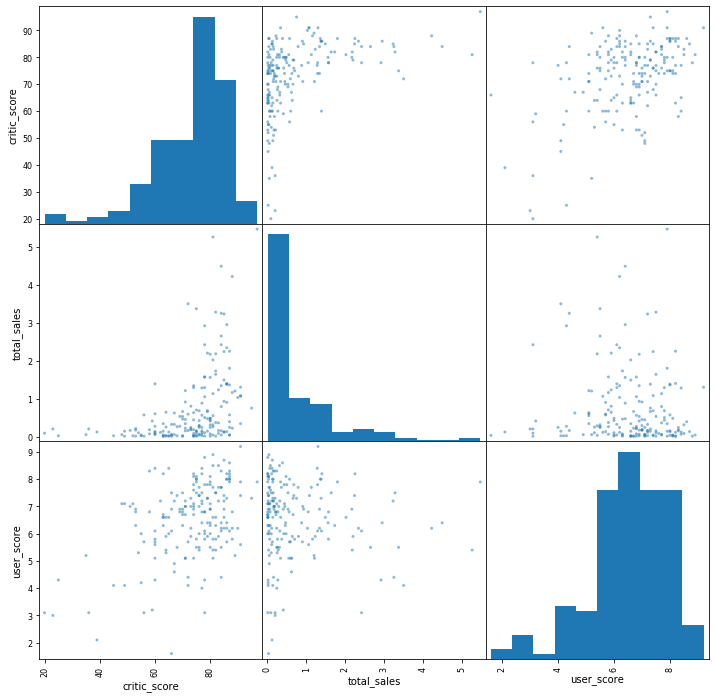

In [64]:
pd.plotting.scatter_matrix(xone_pivot, figsize=(12, 12))
plt.show()

Исследование вляияния продаж на Xbox One показывает аналогичную корреляцию как и на платформе Playstation 4. Это подтверждает вывод слабом влиянии оценки критиков на продажи.

### [3.7 Исследование распределения игр по жанрам.](#games_genre_research)

In [65]:
genre_pivot = stat_current_period.pivot_table(index='genre', values=['name', 'total_sales'], aggfunc=['count', 'mean', 'sum'])
genre_pivot.drop(labels=['name'], level=1, axis=1, inplace=True)
genre_pivot.columns = ['count', 'mean', 'sum']
genre_pivot.reset_index(inplace=True)

In [66]:
genre_pivot

,genre,count,mean,sum
0,Action,769,0.419376,322.50
1,Adventure,245,0.096490,23.64
2,Fighting,80,0.441375,35.31
3,Misc,156,0.404231,63.06
4,Platform,74,0.576081,42.63
5,Puzzle,17,0.186471,3.17
6,Racing,85,0.469294,39.89
7,Role-Playing,293,0.499352,146.31
8,Shooter,187,1.245882,232.98
9,Simulation,62,0.350968,21.76


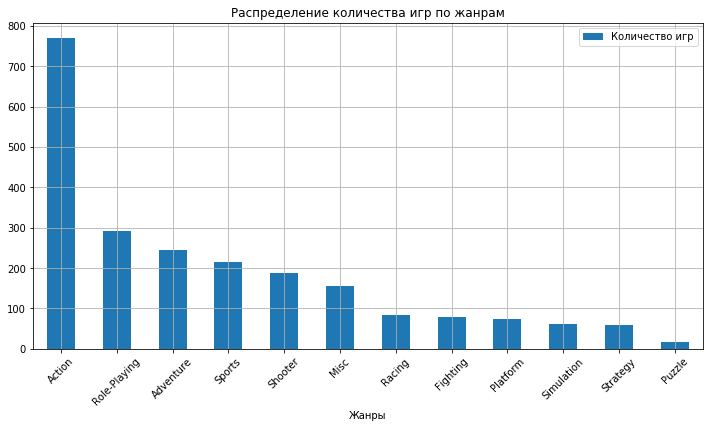

In [67]:
genre_pivot.sort_values(by='count', ascending=False).plot(x='genre', y='count', kind='bar', grid=True, figsize=(12, 6), title='Распределение количества игр по жанрам')
plt.legend(labels=['Количество игр'])
plt.xticks(rotation=45)
plt.xlabel('Жанры')
plt.show()

Больше всего игр выпускается в жанрах экшн, ролевые, приключенческие и спортивные. Наименее популярными жанрами являются паззлы, стратегии и симуляторы.

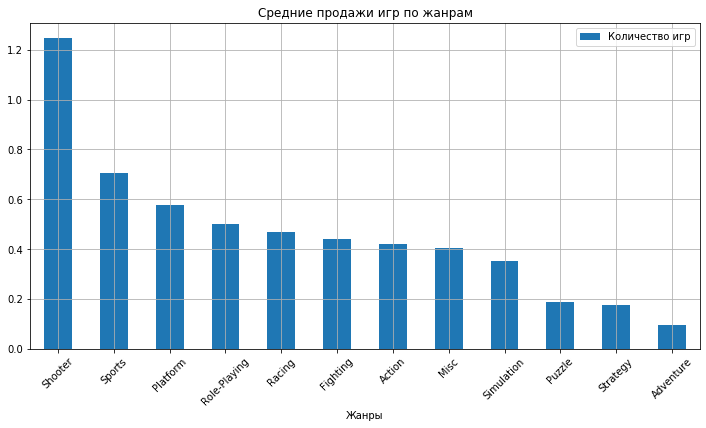

In [68]:
genre_pivot.sort_values(by='mean', ascending=False).plot(x='genre', y='mean', kind='bar', grid=True, figsize=(12, 6), title='Средние продажи игр по жанрам')
plt.legend(labels=['Количество игр'])
plt.xticks(rotation=45)
plt.xlabel('Жанры')
plt.show()

Самые прибыльные играми оказались в жанре шутеров, спортивные и платформеры. Меньше всего денег принесли игры в жанрах пазл, стратегия и приключенческие игры.

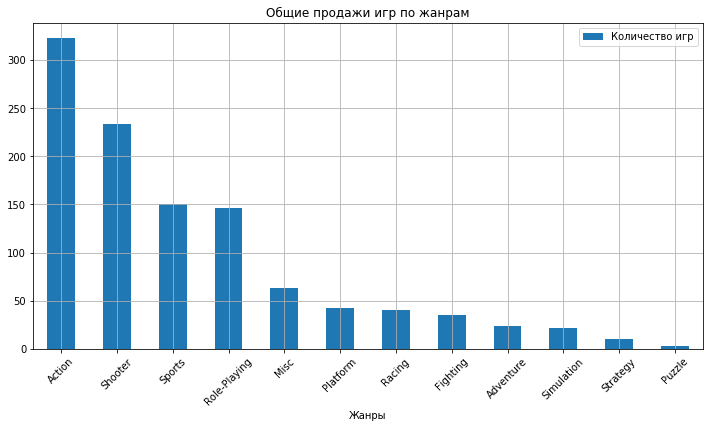

In [69]:
genre_pivot.sort_values(by='sum', ascending=False).plot(x='genre', y='sum', kind='bar', grid=True, figsize=(12, 6), title='Общие продажи игр по жанрам')
plt.legend(labels=['Количество игр'])
plt.xticks(rotation=45)
plt.xlabel('Жанры')
plt.show()

Самыми прибыльными жанрами в сумме оказались жанры экшн, шутеры, спорт и жанр ролевых игр. Жанр пазл, стратегии и симуляторы в сумме принес меньше всего.

## [4. Исследование регионов.](#regoins_research)

### [4.1 Топ 5 платформ по регионам.](#top_5_platforms_by_regions)

Определение какие платформы популярны в различных регионах.

In [70]:
platforms_pivot = stat_current_period.pivot_table(index='platform_fullname', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
platforms_pivot.reset_index(inplace=True)

na_platforms = platforms_pivot[['platform_fullname', 'na_sales']].sort_values(by='na_sales', ascending=False).head(5)
eu_platforms = platforms_pivot[['platform_fullname', 'eu_sales']].sort_values(by='eu_sales', ascending=False).head(5)
jp_platforms = platforms_pivot[['platform_fullname', 'jp_sales']].sort_values(by='jp_sales', ascending=False).head(5)

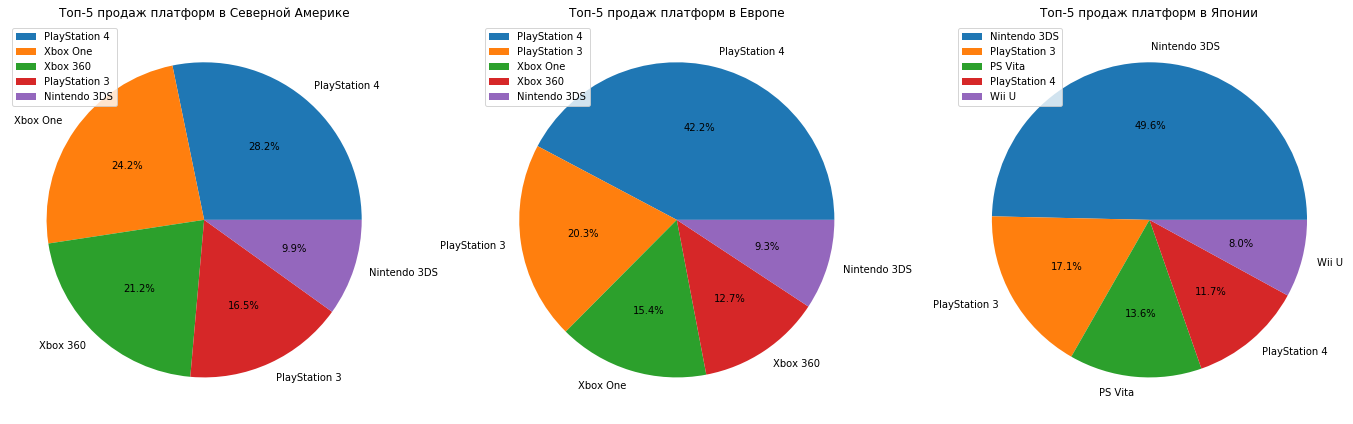

In [71]:
fig_platforms, axis_platforms = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
axis_platforms[0].pie(x=na_platforms['na_sales'], autopct='%0.1f%%', labels=na_platforms['platform_fullname'])
axis_platforms[0].title.set_text('Топ-5 продаж платформ в Северной Америке')
axis_platforms[0].legend(labels=na_platforms['platform_fullname'], loc='upper left')

axis_platforms[1].pie(x=eu_platforms['eu_sales'], autopct='%0.1f%%', labels=eu_platforms['platform_fullname'])
axis_platforms[1].title.set_text('Топ-5 продаж платформ в Европе')
axis_platforms[1].legend(labels=eu_platforms['platform_fullname'], loc='upper left')

axis_platforms[2].pie(x=jp_platforms['jp_sales'], autopct='%0.1f%%', labels=jp_platforms['platform_fullname'])
axis_platforms[2].title.set_text('Топ-5 продаж платформ в Японии')
axis_platforms[2].legend(labels=jp_platforms['platform_fullname'], loc='upper left')

plt.show()

**Северная Америка** является домашним рынком для платформ Xbox, поэтому на этом рынке их доля больше чем на остальных. На первом месте Playstation 4, что показывает большую популярность платформы во всем мире. На втором и третьем месте Xbox One и Xbox 360. \
В **Европе** лидируют Playstation 4, Playstation 3 и Xbox One. Но Playstation 3 пользуется популярностью и после выхода более нового поколения. Xbox One и Xbox 360 менее популярные чем в Северное Америке. \
В **Японии** огромной популярностью пользуются портативные платформы, особенно Nintendo 3DS. Так же Япония единственный регион, где Playstation 3 более популярна чем Playstation 4. И PS Vita на третьем месте, в остальных регионах она не входит в топ-5 платформ.

### [4.2 Топ 5 жанров по регионам.](#top_5_genres_by_regions)

In [72]:
genre_pivot = stat_current_period.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
genre_pivot.reset_index(inplace=True)

na_genres = genre_pivot[['genre', 'na_sales']].sort_values(by='na_sales', ascending=False).head(5)
eu_genres = genre_pivot[['genre', 'eu_sales']].sort_values(by='eu_sales', ascending=False).head(5)
jp_genres = genre_pivot[['genre', 'jp_sales']].sort_values(by='jp_sales', ascending=False).head(5)

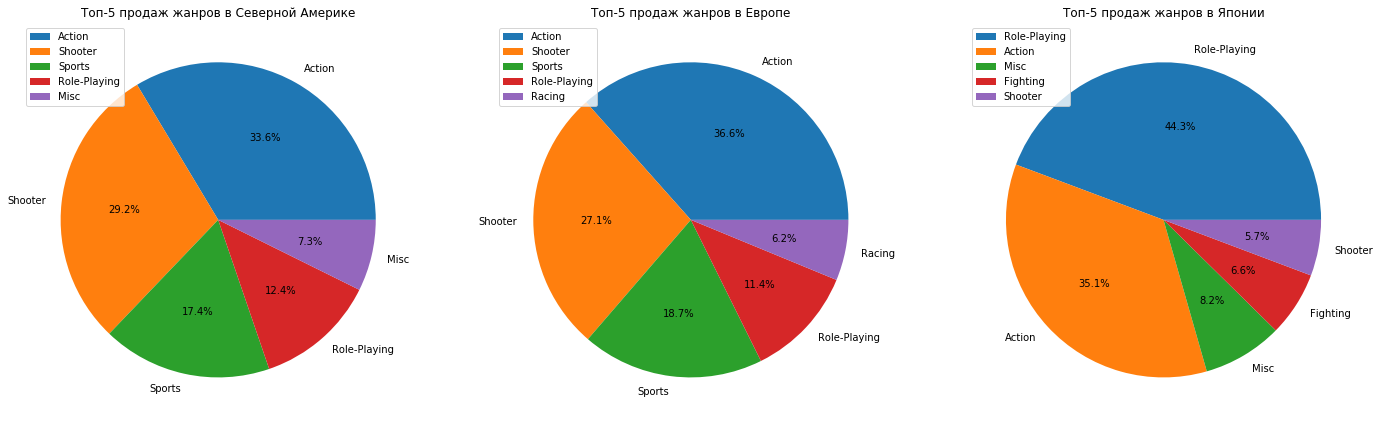

In [73]:
fig_genres, axis_genres = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
axis_genres[0].pie(x=na_genres['na_sales'], autopct='%0.1f%%', labels=na_genres['genre'])
axis_genres[0].title.set_text('Топ-5 продаж жанров в Северной Америке')
axis_genres[0].legend(labels=na_genres['genre'], loc='upper left')

axis_genres[1].pie(x=eu_genres['eu_sales'], autopct='%0.1f%%', labels=eu_genres['genre'])
axis_genres[1].title.set_text('Топ-5 продаж жанров в Европе')
axis_genres[1].legend(labels=eu_genres['genre'], loc='upper left')

axis_genres[2].pie(x=jp_genres['jp_sales'], autopct='%0.1f%%', labels=jp_genres['genre'])
axis_genres[2].title.set_text('Топ-5 продаж жанров в Японии')
axis_genres[2].legend(labels=jp_genres['genre'], loc='upper left')

plt.show()

В регионах **Северная Америка** и **Европа** наибольшей популярностью пользуются жанры экнш, шутеры и жанр спортивных игр. Видимо западные игроки предпочитают примерно одинаковые игры. Популярные спортивные игры выходят для обоих континентов, такие как бейсбол, баскетбол и футбол обоих видов. \
В **Японии** популярны жанры ролевых игр (похоже что это JRPG, например Final Fantasy) и экшены, а так же другие жанры.

### [4.3 Исследование влияния рейтинга ESRB на продажи в отдельном регионе.](#esrb_rating_research)

In [74]:
esrb_pivot = stat_current_period.loc[stat_current_period['rating'] != -1].pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
esrb_pivot.reset_index(inplace=True)

na_rating = esrb_pivot[['rating', 'na_sales']].sort_values(by='na_sales', ascending=False).head(5)
eu_rating = esrb_pivot[['rating', 'eu_sales']].sort_values(by='eu_sales', ascending=False).head(5)
jp_rating = esrb_pivot[['rating', 'jp_sales']].sort_values(by='jp_sales', ascending=False).head(5)

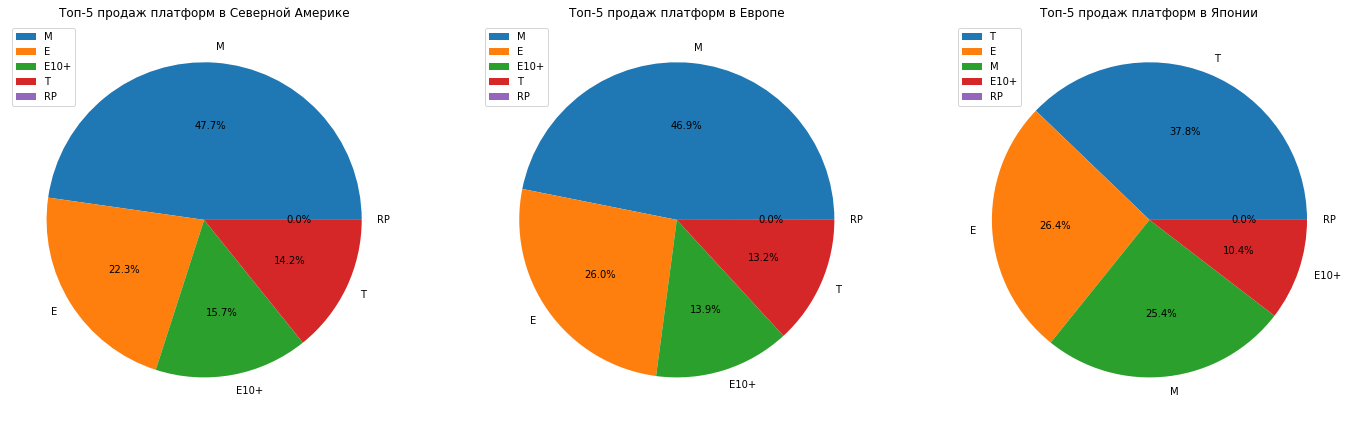

In [75]:
fig_rating, axis_rating = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
axis_rating[0].pie(x=na_rating['na_sales'], autopct='%0.1f%%', labels=na_rating['rating'])
axis_rating[0].title.set_text('Топ-5 продаж платформ в Северной Америке')
axis_rating[0].legend(labels=na_rating['rating'], loc='upper left')

axis_rating[1].pie(x=eu_rating['eu_sales'], autopct='%0.1f%%', labels=eu_rating['rating'])
axis_rating[1].title.set_text('Топ-5 продаж платформ в Европе')
axis_rating[1].legend(labels=eu_rating['rating'], loc='upper left')

axis_rating[2].pie(x=jp_rating['jp_sales'], autopct='%0.1f%%', labels=jp_rating['rating'])
axis_rating[2].title.set_text('Топ-5 продаж платформ в Японии')
axis_rating[2].legend(labels=jp_rating['rating'], loc='upper left')

plt.show()

В **Северной Америке** и **Европе** наиболее прибыльны игры с рейтингом **М** (**Mature** для возраста 17+ лет), **E** (**Everyone** для всех возрастов) и **E10+** (**Everyone** для возраста 10+ лет). Игры с рейтингом **M** ориентированные более на западных игроков создаются с большим бюджетом чем остальные, вероятно эта аудитория наиболее платежеспособная. \
В **Японии** наиболее прибыльны игры с рейтингом **Т** (**Teen** для подростков 13 лет и старше), видимо игры наиболее популярного жанр ролевых игр создаются расчитаны на этот рейтинг. Рейтинг **E** так же занимает второе место, рейтинг **M** не пользуется такой популярностью как на западе. Так же как и игры с рейтингом **E10+**. \

У игр с рейтингом **RP** (Rating Pending - рейтинг не определен, используется для промо материалов) отсутствуют продажи, так как игры без присвоенного возрастного рейтинга не допускаются к продажи.

## [5. Проверка гипотез.](#hypothesis_testing)

### [5.1 Сравнение пользовательских рейтингов игр на платформах Xbox One и PC.](xone_pc_hypothesis)

In [76]:
xone_user_score = stat_current_period.loc[(stat_current_period['platform'] == 'XOne') & (stat_current_period['user_score'] != -1), 'user_score']
pc_user_score = stat_current_period.loc[(stat_current_period['platform'] == 'PC') & (stat_current_period['user_score'] != -1), 'user_score']
alpha_xone_pc_user_score = 0.05

xone_pc_ttest = st.ttest_ind(xone_user_score, pc_user_score)

print('p-значение:', xone_pc_ttest.pvalue)

if (xone_pc_ttest.pvalue < alpha_xone_pc_user_score):
    print('Пользовательские рейтинги платформ Xbox One и PC различаются.')
else: 
    print('Не удалось подтвердить различие пользовательских рейтингов Xbox One и PC.')

p-значение: 0.0929982442808319
Не удалось подтвердить различие пользовательских рейтингов Xbox One и PC.


Нулевая гипотеза: пользовательские рейтинги игр на платформах **Xbox One** и **PC** равны. \
Альтернативная гипотеза: пользовательские рейтинги игр на платформах **Xbox One** и **PC** различаются.

### [5.2 Сравнение пользовательских рейтингов игр в жанрах Action и Sports.](action_sports_hypothesis)

In [77]:
action_user_score = stat_current_period.loc[(stat_current_period['genre'] == 'Action') & (stat_current_period['user_score'] != -1), 'user_score']
sports_user_score = stat_current_period.loc[(stat_current_period['genre'] == 'Sports') & (stat_current_period['user_score'] != -1), 'user_score']
alpha_genre = 0.05

action_sports_ttest = st.ttest_ind(action_user_score, sports_user_score)

print('p-значение:', action_sports_ttest.pvalue)

if (action_sports_ttest.pvalue < alpha_genre):
    print('Пользовательские рейтинги игр в жанрах Action и Sports различаются.')
else: 
    print('Не удалось подтвердить различие пользовательских рейтингов игр в жанрах Action и Sports.')

p-значение: 2.0222152894692334e-31
Пользовательские рейтинги игр в жанрах Action и Sports различаются.


Нулевая гипотеза: пользовательские рейтинги игр в жанрах **Action** и **Sports** равны. \
Альтернативная гипотеза: пользовательские рейтинги игр в жанрах **Action** и **Sports** различаются.

## [6. Общий вывод.](#general_conclusion)

По результатам анализа выявлено что для планирования игр продаж на **2017 год** стоит ориентироваться на игровые платфоры **Playstation 4** и **Xbox One**. Они являются актуальными и наиболее прибыльными на текущих период **с 2013 года**. \
Наиболее перспективным жанром являются **Action**, **Shooter** и **Sports** с возрастным рейтингом **17+**, **для всех возрастов** и **10+ лет**.